# Basic Transfer Learning with Cats and Dogs Data

## Import modules and cats and dogs dataset

In [ ]:
import tensorflow as tf

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.0


In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.0


The easiest way to download and save a file is to use the __urllib.request.urlretrieve__ function:

- import urllib.request
- Download the file from `url` and save it locally under `file_name`:
- urllib.request.urlretrieve(url, file_name)


Using __shutil.copyfile__.
- from shutil import copyfile
- copyfile(src, dst)
- Copy the contents of the file named src to a file named dst.

The OS module in python 
- Provides functions for interacting with the operating system. 
- This module provides a portable way of using operating system dependent functionality. 
- The *os* and *os.path* modules include many functions to interact with the file system.
- __os.getcwd()__: returns the Current Working Directory(CWD) of the file used to execute the code.

In [ ]:
import urllib.request
import os
import zipfile
import random

from shutil import copyfile

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
os.getcwd()

'/content'

In [ ]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'

urllib.request.urlretrieve(data_url, data_file_name)

zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

Check that the dataset is the expected number of examples

In [ ]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


Create some folders that will store the training and test data

In [ ]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  pass

Split data into training and test sets

In [ ]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[:testing_length]

  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [ ]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

In [ ]:
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## Preprocessing Image

Keras __ImageDataGenerator class__ allows to perform image augmentation.

The __ImageDataGenerator class__ has three methods 
- __flow()__, 
- __flow_from_directory()__ and 
- __flow_from_dataframe()__ to read the images from a big numpy array and folders containing images.

The folder names (with respective label names) for the classes are important.

Here are the most used attributes along with the __flow_from_directory() method__.

__train_generator__
- __The directory__ must be set to the path where your ‘n’ classes of folders are present.
- __The target_size__ is the size of your input images, every image will be resized to this size.
- __color_mode__: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
- __batch_size__: No. of images to be yielded from the generator per batch.
- __class_mode__: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the output would probably be the same image, for this case set to “input”.
- __shuffle__: Set True if you want to shuffle the order of the image that is being yielded, else set False.
- __seed__: Random seed for applying random image augmentation and shuffling the order of the image.

__valid_generator__
- Same as train generator settings except for obvious changes like directory path.


__test_generator__
- __directory__: path where there exists a folder, under which all the test images are present. For example, in this case, the images are found in /test/test_images/
- __batch_size__: Set this to some number that divides your total number of images in your test set exactly.
- __class_mode__: Set this to None, to return only the images.
- __shuffle__: Set this to False, because you need to yield the images in “order”, to predict the outputs and match them with their unique ids or filenames.


In [ ]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=100, 
                                                    class_mode='binary', 
                                                    target_size=(150, 150))


VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                              batch_size=100, 
                                                              class_mode='binary', 
                                                              target_size=(150, 150))

Found 22499 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Get and Prepare the Model

Transfer learning using the `InceptionV3` model.  
- You'll load the pre-trained weights of the model.
- You'll also freeze the existing layers so that they aren't trained on your downstream task with the cats and dogs data.
- You'll also get a reference to the last layer, 'mixed7' because you'll add some layers after this last layer.

In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"

urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False, 
                                weights=None)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


## Add Layers


Add some layers that you will train on the cats and dogs data.

- __Flatten__: This will take the output of the last_layer and flatten it to a vector.
- __Dense__: You'll add a dense layer with a relu activation.
- __'Dense'__: After that, add a dense layer with a sigmoid activation. The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1.024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

## Train the model

Compile the model and then train it on the test data using model.fit

In [ ]:
# Compile the model
model.compile(optimizer=RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [ ]:
# Train the model
import time

start = time.time()

history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=20, 
    verbose=1)

print()
print('Time: {:.2f} minutes'.format((time.time()-start)/60))

Epoch 1/20
  8/225 [>.............................] - ETA: 2:08 - loss: 1.2887 - acc: 0.7387

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 181s 803ms/step - loss: 0.2350 - acc: 0.9083 - val_loss: 0.0935 - val_acc: 0.9696
Epoch 2/20
225/225 [==============================] - 179s 794ms/step - loss: 0.1519 - acc: 0.9384 - val_loss: 0.0699 - val_acc: 0.9764
Epoch 3/20
225/225 [==============================] - 176s 781ms/step - loss: 0.1399 - acc: 0.9442 - val_loss: 0.0740 - val_acc: 0.9744
Epoch 4/20
225/225 [==============================] - 175s 777ms/step - loss: 0.1345 - acc: 0.9469 - val_loss: 0.0992 - val_acc: 0.9716
Epoch 5/20
225/225 [==============================] - 176s 783ms/step - loss: 0.1325 - acc: 0.9482 - val_loss: 0.0695 - val_acc: 0.9768
Epoch 6/20
225/225 [==============================] - 175s 777ms/step - loss: 0.1268 - acc: 0.9507 - val_loss: 0.0715 - val_acc: 0.9776
Epoch 7/20
225/225 [==============================] - 173s 769ms/step - loss: 0.1198 - acc: 0.9551 - val_loss: 0.0706 - val_acc: 0.9800
Epoch 8/20
225/225 [==============================] - 172s 

## Visualize the training and validation accuracy

<Figure size 432x288 with 0 Axes>

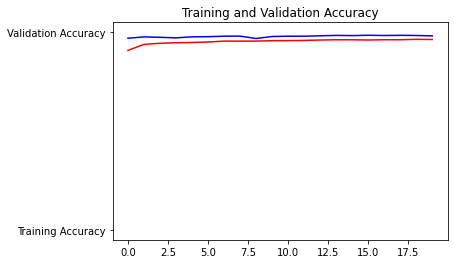

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Retrieve a list results on training and test data sets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.figure()

## Predict on a test image

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # Predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Captura de tela de 2020-11-30 21-29-54.png to Captura de tela de 2020-11-30 21-29-54.png
[[0.]]
[0.]
Captura de tela de 2020-11-30 21-29-54.png is a cat
